# Векторные представления

Векторные представления как и многие другие вещи в датасаенсе раскрываются на огромных текстовых коллекция. Невозможно испортить векторную модель слишком большим количеством текста - она в любом случае будет только лучше. И наибольшую популярность эмбединги получили как раз тогда, когда придумали как обучаться на больших данных. Вектора, выложенные в общий доступ, в большинстве случаев обучены на корпусах из сотен миллинов токенов. 

Может показаться, что обучать свои представления, это безнадежное занятие - они все-равно не сравнятся с тем, что обучил гугл или фейсбук. Это не так. Хорошие эмбединги можно получить на совсем небольшом корпусе и иногда они могут даже оказаться лучше. Корпуса на которых обучают эбмеддинги - это чаще всего дампы википедии, новостные тексты и весь интернет подряд. Текстов по вашей специфичной теме там может не быть совсем или они утонут в куче однотипных новостей. 

Поэтому боятся обучать свои эмбединги не стоит. Тем более, что с генсимом и склерном это делается очень просто и быстро.

In [1]:
import pandas as pd
from lxml import html
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.ensemble import RandomForestClassifier
import gensim
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter,defaultdict
from string import punctuation
import os
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
%matplotlib inline

morph = MorphAnalyzer()
punct = punctuation+'«»—…“”*№–'
stops = set(stopwords.words('russian'))

def normalize(text):
    
    words = [word.strip(punct) for word in text.lower().split()]
    words = [morph.parse(word)[0].normal_form for word in words if word and word not in stops]

    return ' '.join(words)

def tokenize(text):
    
    words = [word.strip(punct) for word in text.lower().split()]

    return ' '.join(words)


/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Давайте соберем небольшой корпус гуманитарных текстов (лингвистика, социология, история, философия) с сайта krugosvet.

In [30]:
# import requests
# from lxml import etree, html
# from time import sleep

In [80]:
# links = []

In [82]:
# # лингвистика
# for topic in [33, 37, 10, 13, 36, 12, 34, 39]:
#     for letter in 'абвгдезиклмнпростуфхцшщчуэюя':
#         for page_num in range(0, 30, 1):
#             r = requests.get(f'https://www.krugosvet.ru/taxonomy/term/{topic}/{letter}?page={page_num}')
#             if r.status_code != 200:
#                 continue
#             page = html.fromstring(r.text)
#             hrefs = page.xpath("//div[@class='article-teaser']/a/@href")
#             links += ['https://www.krugosvet.ru'+href for href in hrefs]
            
#     print('after topic - ', topic, ', links collected - ', len(links))

after topic -  33 , links collected -  586
after topic -  37 , links collected -  1523
after topic -  10 , links collected -  1683
after topic -  13 , links collected -  3444
after topic -  36 , links collected -  3803
after topic -  12 , links collected -  3875
after topic -  34 , links collected -  4103
after topic -  39 , links collected -  6083


In [90]:
# texts = []

# for link in tqdm(links):
#     r = requests.get(link)
#     if r.status_code != 200:
#         continue
#     page = html.fromstring(r.text)
#     text = "".join(page.xpath("//div[@id='article-content']/div[@class='body']//text()"))
#     texts.append(text)
    
    

100%|██████████| 6083/6083 [17:56<00:00,  5.65it/s]


In [115]:
# corpus_hum = open('corpus_hum.txt', 'w')

# for text in texts:
#     if len(text)>10:
#         corpus_hum.write(text + '\n')

# corpus_hum.close()

Откроем получившийся корпус.

In [2]:
data = open('corpus_hum.txt').read().splitlines()

data_norm = [normalize(text) for text in data]

In [3]:
data_norm = [text for text in data_norm if text]

In [234]:
data_norm[:5]

['абай василий васо иван 1900–2001 русский лингвист родиться 2 15 декабрь 1900 с.коби тифлисский губерния ныне грузия 1925 окончить факультет общественный наука ленинградский университет 1928 аспирантура 1928–1930 сотрудник кавказский историко-археологический институт ан ссср 1930 полвека работать яфетический институт затем институт язык мышление институт языкознание ан ссср ленинград 1950 москва доктор филологический наука 1962 профессор 1969 лауреат государственный премия ссср 1981 почётный член азиатский королевский общество великобритания ирландия 1966 член-корреспондент финно-угорский общество хельсинки 1973 умереть абай москва 18 март 2001',
 'также тема',
 'лингвистика языкознание языковедение',
 'ученик н.я.марра ранний работа находиться влияние идея который впоследствии отойти видный специалист история иранский язык свой родной осетинский язык автор фундаментальный историко-этимологический словарь осетинский язык 5-ти том 1958–1990 заниматься также мифология фольклор иранский 

In [4]:
len(data_norm)

115082

## Матричные разложения

Попробуем сначала матричные разложения. В SVD и в NMF одна из получаемых матриц имеет размерность (количество слов, количесто "тем"). Вектора из этих матриц и будут искомыми эбмедингами.

Для построение изнчальной матрицы слова на документы воспользуемся CountVectorizer из sklearn.

In [5]:
cv = CountVectorizer(min_df=3, max_df=0.4, max_features=1000)
X = cv.fit_transform(data_norm)

In [6]:
X.shape

(115082, 1000)

Разложим матрицу. Сначала попробуем только две размерности, чтобы визуализировать вектора.

In [7]:
svd = TruncatedSVD(2)
svd.fit(X)

TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0)

In [306]:
# можно использовать побольше размерность, но тогда не получится визуализовать напрямую
# можно дополнительно пропустить через TSNE - метод специально для визуализации
# svd = TruncatedSVD(200)
# svd.fit(X)
# tsne = TSNE(2).fit_transform(svd.components_.T)

In [8]:
id2word = {i:w for i,w in enumerate(cv.get_feature_names())}
word2id = {w:i for i,w in id2word.items()}

Попробуем визуализировать полученные вектора. Все слова визуализировать не получится, но можно попробовать взять какое-то количество случайных слов.

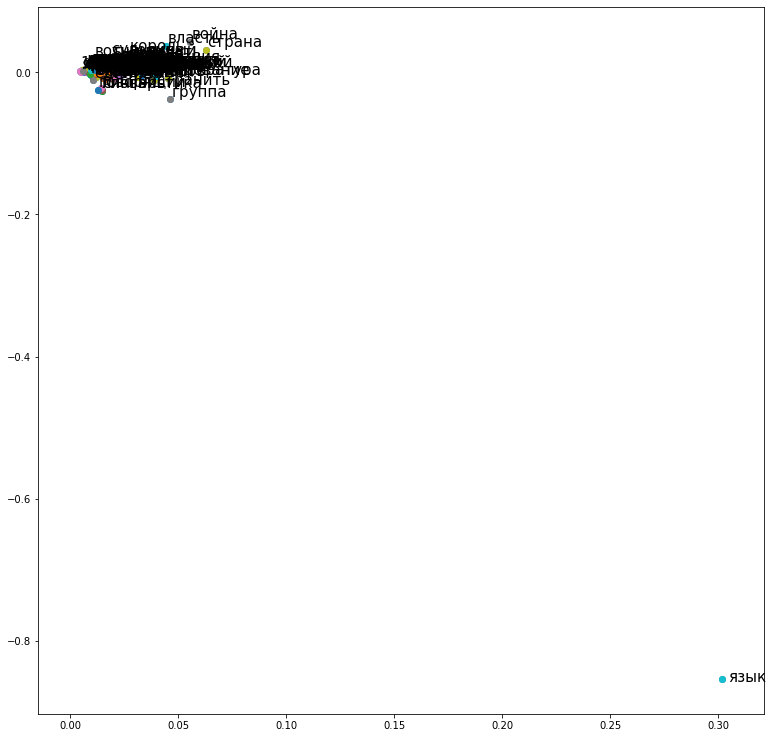

In [9]:
random_inds = np.random.choice(range(len(id2word)), 100, replace=False) 
res = svd.components_.T[random_inds] # закомментируйте эту ячейку для TSNE
# res = tsne[random_inds] # а эту наоборот раскомментируйте

plt.figure(figsize=(13,13))
plt.scatter(res[:,0], res[:,1])
for i, coor in enumerate(random_inds):
    x, y = res[i, 0], res[i, 1]
    plt.scatter(x, y)
    
    plt.annotate(id2word[coor], xy=(x, y), xytext=(x*1.01, y*1.01), textcoords='data',
                   ha='left', va='bottom', fontsize=15)

Получается не очень красиво. Почти все слова сбиваются в кучу. 

Но визуализация ещё ничего не говорит. Посмотрим на близкие слова.

Перестроим разложения с большим количеством параметров.

In [10]:
nmf = NMF(50)
nmf.fit(X)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=50, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [11]:
svd = TruncatedSVD(50)
svd.fit(X)

TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0)

In [12]:
id2word = {i:w for i,w in enumerate(cv.get_feature_names())}
word2id = {w:i for i,w in id2word.items()}

In [13]:
id2vec_svd = nmf.components_.T

In [14]:
id2vec_nmf = svd.components_.T

In [15]:
def most_similar(word, id2vec):
    similar = [id2word[i] for i in cosine_distances(id2vec[word2id[word]].reshape(1, -1), id2vec).argsort()[0][:10]]
    return similar

In [16]:
most_similar('владимир', id2vec_svd)
# попробуйте другие слова

['владимир',
 'иван',
 'князь',
 'земля',
 'царь',
 'московский',
 'великий',
 'монастырь',
 'великое',
 'небо']

In [17]:
most_similar("владимир", id2vec_nmf)

['владимир',
 'иван',
 'князь',
 'московский',
 'александр',
 'царь',
 'брат',
 'москва',
 'великий',
 'земля']

По похожим словам вектора выглядят достаточно хорошо.

Попробуем ещё кластеризовть полученные слова. Одна из метрик хороших векторов - их кластеризуемость (т.е. насколько хорошие получаются кластеры, можно ли сразу дать им какое-то название).

Сделаем кластеризацию с помощью MiniBatchKmeans.

In [32]:
cluster = MiniBatchKMeans(30, n_init=2, verbose=1, max_no_improvement=100, reassignment_ratio=0.4)
cluster.fit(nmf.components_.T)

Сохраним кластеры в текстовый файл и просто полистаем.

In [333]:

cls = defaultdict(list)

for i, cl in enumerate(cluster.labels_):
    cls[cl].append(id2word[i])
# откройте в любом текстовом редакторе
f = open('cluster_nmf.txt', 'w')
for cl in cls:
    f.write('### '+ str(cl) + ' ###\n')
    f.write('\n'.join(cls[cl]))
    f.write('\n\n')
f.close()

## Word2Vec и Fasttext

Проделаем тоже самое для ворд2века и фастекста. 

Интерфейс в gensim практически такой же как и в LDA. Только строить словарь не нужно.

In [18]:
fast_text = gensim.models.FastText([text.split() for text in data_norm], size=50, 
                                   min_n=4, max_n=8) 
w2v = gensim.models.Word2Vec([text.split() for text in data_norm], size=50, sg=1)


/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


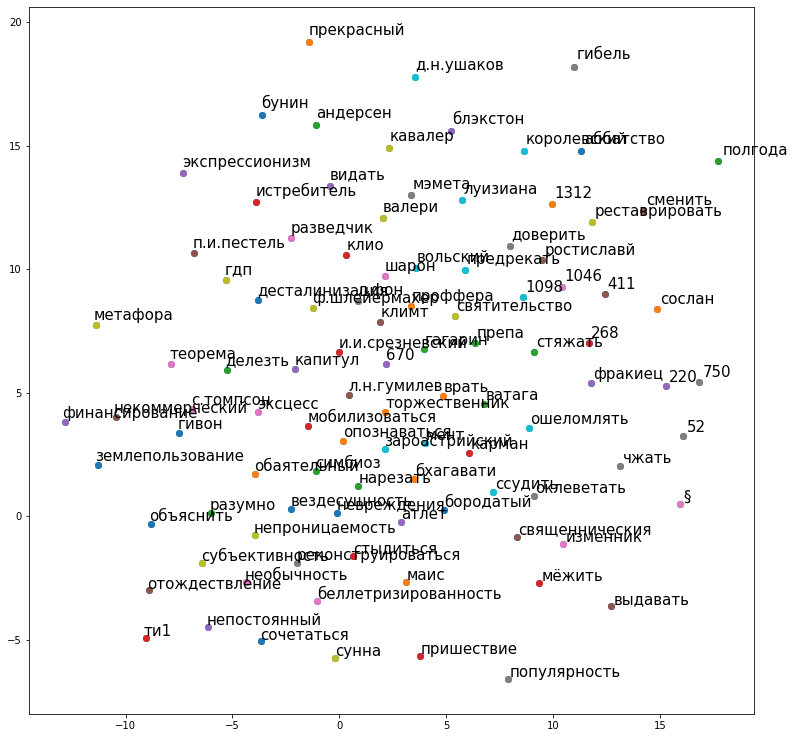

In [19]:
random_words = np.random.choice(w2v.wv.index2word, 100, replace=False)
res = w2v[random_words]
res = TSNE(2).fit_transform(res)

plt.figure(figsize=(13,13))
plt.scatter(res[:,0], res[:,1])
for i, coor in enumerate(res):
    x, y = coor
    plt.scatter(x, y)
    
    plt.annotate(random_words[i], xy=(x, y), xytext=(x*1.01, y*1.01), textcoords='data',
                   ha='left', va='bottom', fontsize=15)

Опять же ничего хорошего на график не рисуется.

Посмотрим на близкие слова.

In [27]:
fast_text.most_similar('язык')
# чтобы отчетливо увидеть различия фастекста и ворд2века
# подставьте какое-то несуществующее слово (например, с опечаткой или с говорящей частью - "хренология" хороший пример)
# или попробуйте ввести слово с характерной составляющей (суффиксом прошедшего времени, приставкой пере)

/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('н.м.язык', 0.9949963092803955),
 ('праязык', 0.9454808235168457),
 ('подъязык', 0.9194867610931396),
 ('язык-предок', 0.8936646580696106),
 ('языкова', 0.8671830296516418),
 ('язык-цель', 0.850830614566803),
 ('метаязык', 0.8380059003829956),
 ('протоязык', 0.8032997846603394),
 ('языковед', 0.779621958732605),
 ('диалект', 0.7663685083389282)]

In [28]:
w2v.most_similar('язык')

/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('древнееврейский', 0.8318796157836914),
 ('иврит', 0.7822853326797485),
 ('латынь', 0.7792429327964783),
 ('идиш', 0.7611494660377502),
 ('подлинник', 0.7582873702049255),
 ('церковно-славянский', 0.7511679530143738),
 ('старофранцузский', 0.749047040939331),
 ('фарси', 0.748748779296875),
 ('перевод', 0.7477747201919556),
 ('двуязычный', 0.7475094795227051)]

Ну и на кластеры давайте тоже посмотрим.

In [29]:
vocab = fast_text.wv.index2word
matrix = np.zeros((len(vocab), 50))

for i, word in enumerate(vocab):
    if word in vocab:
        matrix[i] = fast_text[word]

/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [31]:
cluster = MiniBatchKMeans(1000, n_init=2, verbose=1, max_no_improvement=300, reassignment_ratio=0.4)
cluster.fit(matrix)
cls = defaultdict(list)

for i, cl in enumerate(cluster.labels_):
    cls[cl].append(vocab[i])

f = open('cluster_ft.txt', 'w')
for cl in cls:
    f.write('### '+ str(cl) + ' ###\n')
    f.write('\n'.join(cls[cl]))
    f.write('\n\n')
f.close()

Преимущество фастекста в том, что он учитывает символьные нграммы (что примерно равно учету морфологии). Попробуем подать ему на вход ненормализованные тексты.

In [270]:
corpus = [tokenize(text).split() for text in data]
corpus = list(filter(bool, corpus))
fast_text = gensim.models.FastText(corpus, size=50)

In [30]:
vocab = fast_text.wv.index2word
matrix = np.zeros((len(vocab), 50))

for i, word in enumerate(vocab):
    if word in vocab:
        matrix[i] = fast_text[word]
        
cluster = MiniBatchKMeans(1000, n_init=2, verbose=1, max_no_improvement=300, reassignment_ratio=0.4)
cluster.fit(matrix)
cls = defaultdict(list)

for i, cl in enumerate(cluster.labels_):
    cls[cl].append(vocab[i])

f = open('cluster_ft.txt', 'w')
for cl in cls:
    f.write('### '+ str(cl) + ' ###\n')
    f.write('\n'.join(cls[cl]))
    f.write('\n\n')
f.close()

### Векторные представления в настоящей задаче

Все вышеперечисленое относится к intrinsic (внутренним) метрикам. Есть также много других схожих (аналогии, корреляция с оценками людей и т.д). Но эти метрики не всегда показывают какой из методов сработает в реальной задаче. Поэтому при выборе методов и подборе параметров лучше ориентироваться на оценки качества решаемой задачи.

Проверим как все эти методы работают на задаче определения парафразов (предложений, которые выражают одно и то же, но не равны друг другу).

Данные взяты вот отсюда: http://paraphraser.ru/

Коллекция состоит из пар предложения (заголвков статей) и метки класса (-1,0,1). -1 не парафраз, 1 - парафраз, 0 - что-то непонятное.

In [356]:
corpus_xml = html.fromstring(open('paraphraser/paraphrases.xml', 'rb').read())
texts_1 = []
texts_2 = []
classes = []

for p in corpus_xml.xpath('//paraphrase'):
    texts_1.append(p.xpath('./value[@name="text_1"]/text()')[0])
    texts_2.append(p.xpath('./value[@name="text_2"]/text()')[0])
    classes.append(p.xpath('./value[@name="class"]/text()')[0])
    
data = pd.DataFrame({'text_1':texts_1, 'text_2':texts_2, 'label':classes})

In [357]:
data['text_1_norm'] = data['text_1'].apply(normalize)
data['text_2_norm'] = data['text_2'].apply(normalize)

In [275]:
data.head(2)

,label,text_1,text_2,text_1_norm,text_2_norm
0,0,Полицейским разрешат стрелять на поражение по ...,Полиции могут разрешить стрелять по хулиганам ...,полицейский разрешить стрелять поражение гражд...,полиция мочь разрешить стрелять хулиган травма...
1,0,Право полицейских на проникновение в жилище ре...,Правила внесудебного проникновения полицейских...,право полицейский проникновение жилища решить ...,правило внесудебный проникновение полицейский ...


Тексты короткие и их маловато, поэтому возьмем модели, обученные на новостных текстах.

Для решения задачи преобразуем каждый текст и конкатенируем их векторы.

In [358]:
tfidf = TfidfVectorizer(min_df=3, max_df=0.4, max_features=1000)
tfidf.fit(pd.concat([data['text_1_norm'], data['text_2_norm']]))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.4, max_features=1000, min_df=3,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

### SVD

In [359]:
svd = TruncatedSVD(200)

X_text_1 = svd.fit_transform(tfidf.transform(data['text_1_norm']))
X_text_2 = svd.fit_transform(tfidf.transform(data['text_2_norm']))

X_text = np.concatenate([X_text_1, X_text_2], axis=1)

In [360]:
X_text.shape

(7227, 400)

In [361]:
y = data['label'].values
print(y.shape)

(7227,)


Для простоты не будем использовать кросс-валидацию, а просто разобьем на трейн и тест. Зафиксируем сид, чтобы каждый раз получалось одинаковое разбиение.

In [362]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text, y, random_state=1)
clf = LogisticRegression(C=1000, class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

         -1       0.51      0.53      0.52       629
          0       0.48      0.46      0.47       737
          1       0.35      0.34      0.35       441

avg / total       0.46      0.46      0.46      1807



In [363]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text, y, random_state=1)
clf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=10,
                             class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

         -1       0.54      0.51      0.52       629
          0       0.48      0.56      0.52       737
          1       0.38      0.30      0.34       441

avg / total       0.48      0.48      0.48      1807



### NMF

Точно также (делаем пару векторов, конкатенируем, суём в логрег или рандом форест)

In [364]:
X_text_1_nmf = nmf.transform(tfidf.transform(data['text_1_norm']))
X_text_2_nmf = nmf.transform(tfidf.transform(data['text_2_norm']))

X_text_nmf = np.concatenate([X_text_1_nmf, X_text_2_nmf], axis=1)

In [365]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text_nmf, y,random_state=1)
clf = LogisticRegression(C=10000, class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

         -1       0.42      0.41      0.41       629
          0       0.43      0.57      0.49       737
          1       0.29      0.15      0.19       441

avg / total       0.39      0.41      0.39      1807



In [366]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text_nmf, y,random_state=1)
clf = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=15,
                             class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

         -1       0.52      0.50      0.51       629
          0       0.49      0.42      0.45       737
          1       0.33      0.42      0.37       441

avg / total       0.46      0.45      0.45      1807



### Word2Vec и Fastext

Преобразование текста в вектор с помощью w2v и fasttext не тривиальная задача. Самый простой и распространенный способ - усреднение отдельных векторов слов. Можно ещё использовать tfidf отдельных слов, для взвешивания отдельных векторов (чтобы частотные векторы не утягивали все на себя).

In [367]:
def get_embedding(text, model, dim):
    text = text.split()
    
    # чтобы не доставать одно слово несколько раз
    # сделаем счетчик, а потом векторы домножим на частоту
    words = Counter(text)
    total = len(text)
    vectors = np.zeros((len(words), dim))
    
    for i,word in enumerate(words):
        try:
            v = model[word]
            vectors[i] = v*(words[word]/total) # просто умножаем вектор на частоту
        except (KeyError, ValueError):
            continue
    
    if vectors.any():
        vector = np.average(vectors, axis=0)
    else:
        vector = np.zeros((dim))
    
    return vector
        

In [368]:
dim = 50
X_text_1_w2v = np.zeros((len(data['text_1_norm']), dim))
X_text_2_w2v = np.zeros((len(data['text_2_norm']), dim))

for i, text in enumerate(data['text_1_norm'].values):
    X_text_1_w2v[i] = get_embedding(text, w2v, dim)
    
for i, text in enumerate(data['text_2_norm'].values):
    X_text_2_w2v[i] = get_embedding(text, w2v, dim)

/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [369]:
X_text_w2v = np.concatenate([X_text_1_w2v, X_text_2_w2v], axis=1)

In [370]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text_w2v, y,random_state=1)
clf = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=15,
                             class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

         -1       0.60      0.52      0.56       629
          0       0.48      0.53      0.50       737
          1       0.39      0.39      0.39       441

avg / total       0.50      0.49      0.50      1807



In [371]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text_w2v, y,random_state=1)
clf = LogisticRegression(C=1000)
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

         -1       0.45      0.45      0.45       629
          0       0.45      0.67      0.54       737
          1       0.46      0.07      0.12       441

avg / total       0.45      0.45      0.41      1807



In [372]:
dim = 50
data['text_1_notnorm'] = data['text_1'].apply(tokenize)
data['text_2_notnorm'] = data['text_2'].apply(tokenize)

X_text_1_ft = np.zeros((len(data['text_1_notnorm']), dim))
X_text_2_ft = np.zeros((len(data['text_2_notnorm']), dim))

for i, text in enumerate(data['text_1_notnorm'].values):
    X_text_1_ft[i] = get_embedding(text, fast_text, dim)
    
for i, text in enumerate(data['text_2_notnorm'].values):
    X_text_2_ft[i] = get_embedding(text, fast_text, dim)

/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [ ]:
cosine_distance(X[i], X[i])

In [373]:
X_text_ft = np.concatenate([X_text_1_ft, X_text_2_ft], axis=1)

In [374]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text_ft, y,random_state=1)
clf = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=15,
                             class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

         -1       0.52      0.57      0.54       629
          0       0.51      0.45      0.48       737
          1       0.41      0.41      0.41       441

avg / total       0.49      0.49      0.48      1807



### Использование предобученных моделей

Определение перефразирования сделано на новостных текстах и предобученные открытые модели тут подойдут. Для русского готовые модели можно взять на сайте https://rusvectores.org/ru/models/ 

Нужно скачать какую-то модели, распаковать и открыть в генсиме.


In [7]:
# я скачал вот эту tayga_upos_skipgram_300_2_2019 
# и распаковал архив в папку taiga_w2v_model
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('taiga_w2v_model/model.bin', binary=True)

/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [8]:
model.most_similar('февраль_NOUN')

[('март_NOUN', 0.9567033052444458),
 ('ноябрь_NOUN', 0.9523458480834961),
 ('декабрь_NOUN', 0.9509049654006958),
 ('апрель_NOUN', 0.949961245059967),
 ('январь_NOUN', 0.9472224712371826),
 ('октябрь_NOUN', 0.937659740447998),
 ('май_NOUN', 0.911928117275238),
 ('июнь_NOUN', 0.9011650681495667),
 ('сентябрь_NOUN', 0.899361252784729),
 ('июль_NOUN', 0.8842827677726746)]

Слова в модели хранятся в нормализованном виде с прибавленной частью речи. Для пребобработки там использовался udpipe, вызывать его в тетрадке неудобно, поэтому можно заменить его на майстем (по большей части все будет совпадать). На сайте есть ссылка на файл с соответствием тэгов майстема тэгам Udpipe (https://github.com/akutuzov/universal-pos-tags/blob/4653e8a9154e93fe2f417c7fdb7a357b7d6ce333/ru-rnc.map)

In [377]:
mapping = {}

for line in open('ru-rnc.map.txt'):
    ms, ud = line.strip('\n').split()
    mapping[ms] = ud

In [378]:
mapping

{'A': 'ADJ',
 'ADV': 'ADV',
 'ADVPRO': 'ADV',
 'ANUM': 'ADJ',
 'APRO': 'DET',
 'COM': 'ADJ',
 'CONJ': 'SCONJ',
 'INTJ': 'INTJ',
 'NONLEX': 'X',
 'NUM': 'NUM',
 'PART': 'PART',
 'PR': 'ADP',
 'S': 'NOUN',
 'SPRO': 'PRON',
 'UNKN': 'X',
 'V': 'VERB'}

In [1]:
from pymystem3 import Mystem
m = Mystem()

In [2]:

def normalize_mystem(text):
    tokens = []
    norm_words = m.analyze(text)
    for norm_word in norm_words:
        if 'analysis' not in norm_word:
            continue
        lemma = norm_word["analysis"][0]["lex"].lower().strip()
        pos = norm_word["analysis"][0]["gr"].split(',')[0]
        pos = pos.split('=')[0].strip()
        pos = mapping[pos]
        tokens.append(lemma+'_'+pos)
    return tokens


Эту функцию можно применять к любому тексты и получать на выходе токены, по которым можно обращаться к модели напрямую.

In [108]:
normalize_mystem('Обучить классификатор парафразов на предобученной модели вам нужно будет дома')

['обучать_VERB',
 'классификатор_NOUN',
 'парафраз_NOUN',
 'на_ADP',
 'предобученный_ADJ',
 'модель_NOUN',
 'вы_PRON',
 'нужно_ADV',
 'быть_VERB',
 'дома_ADV']

Векторизовать тексты и обучать классификаторы вы уже умеете. Проверить лучше ли работает предобученная модель, чем та, что мы обучили сами, вы тоже сможете!